In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
country = "US"
#country = 'India'

#Total COVID confirmed cases
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
#df_confirmed.to_csv('global.csv')

In [2]:
df_confirmed.shape

(280, 734)

In [3]:
df_confirmed.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/12/21,12/13/21,12/14/21,12/15/21,12/16/21,12/17/21,12/18/21,12/19/21,12/20/21,12/21/21,12/22/21,12/23/21,12/24/21,12/25/21,12/26/21,12/27/21,12/28/21,12/29/21,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22,1/10/22,1/11/22,1/12/22,1/13/22,1/14/22,1/15/22,1/16/22,1/17/22,1/18/22,1/19/22,1/20/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,...,157633,157648,157660,157665,157725,157734,157745,157787,157797,157816,157841,157878,157887,157895,157951,157967,157998,158037,158056,158084,158107,158189,158183,158205,158245,158275,158300,158309,158381,158394,158471,158511,158602,158639,158678,158717,158826,158974,159070,159303
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,203787,203925,204301,204627,204928,205224,205549,205777,205897,206273,206616,206935,207221,207542,207709,207709,208352,208899,208899,210224,210224,210885,210885,212021,212021,213257,214905,214905,219694,220487,222664,224569,226598,228777,230940,232637,233654,236486,239129,241512
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,212848,213058,213288,213533,213745,214044,214330,214592,214835,215145,215430,215723,216098,216376,216637,216930,217265,217647,218037,218432,218818,219159,219532,219953,220415,220825,221316,221742,222157,222639,223196,223806,224383,224979,225484,226057,226749,227559,228918,230470
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,19440,19440,20136,20136,20549,20549,20549,20549,21062,21062,21372,21571,21730,21730,21730,22332,22540,22823,23122,23740,23740,23740,24502,24802,25289,25289,26408,26408,26408,27983,28542,28899,28899,29888,29888,29888,29888,29888,29888,32201
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,65404,65404,65431,65565,65648,65760,65868,65938,66086,66566,67199,68362,70221,71142,71752,71752,76787,78475,79871,81593,82398,82920,83764,84666,86636,87625,88775,89251,89718,90316,91148,91907,92581,93302,93524,93694,93974,94275,94779,95220


In [4]:
df_confirmed_country = df_confirmed[df_confirmed["Country/Region"] == country]

In [5]:
df_confirmed_country

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/12/21,12/13/21,12/14/21,12/15/21,12/16/21,12/17/21,12/18/21,12/19/21,12/20/21,12/21/21,12/22/21,12/23/21,12/24/21,12/25/21,12/26/21,12/27/21,12/28/21,12/29/21,12/30/21,12/31/21,1/1/22,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22,1/10/22,1/11/22,1/12/22,1/13/22,1/14/22,1/15/22,1/16/22,1/17/22,1/18/22,1/19/22,1/20/22
255,NaN,US,40.0,-100.0,1,1,2,2,5,5,5,6,6,8,8,8,11,11,11,12,12,12,12,12,13,13,14,14,14,14,14,14,14,14,16,16,16,16,16,16,...,49945270,50132562,50248657,50392791,50534536,50727490,50803969,50890881,51133117,51312239,51554047,51823460,52043195,52100664,52283812,52828745,53185333,53684471,54277254,54751979,54869926,55121471,56299922,57105467,57748242,58563290,59418388,59799869,60272804,61642030,62410275,63318131,64155793,64963939,65497024,65908656,66615031,67672872,68663297,69308111


In [6]:

df_confirmed_country = pd.DataFrame(df_confirmed_country[df_confirmed_country.columns[4:]].sum(),columns=["confirmed"])
df_confirmed_country

,confirmed
1/22/20,1
1/23/20,1
1/24/20,2
1/25/20,2
1/26/20,5
...,...
1/16/22,65908656
1/17/22,66615031
1/18/22,67672872
1/19/22,68663297


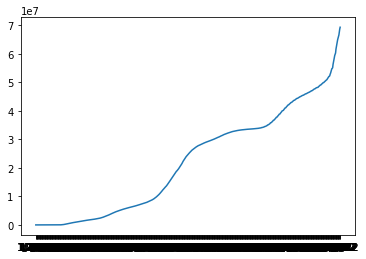

In [7]:
plt.plot(df_confirmed_country)

In [8]:
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index,format='%m/%d/%y')


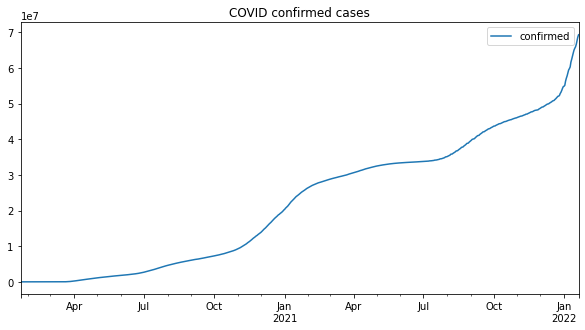

In [9]:

df_confirmed_country.plot(figsize=(10,5),title="COVID confirmed cases")

In [10]:
x = len(df_confirmed_country)-14

train=df_confirmed_country.iloc[:x]
test = df_confirmed_country.iloc[x:]


In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [12]:

from keras.preprocessing.sequence import TimeseriesGenerator

In [30]:

seq_size = 10  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)



In [31]:
x,y = train_generator[10]  #Check train_generator
x.shape,y.shape

((1, 10, 1), (1, 1))

In [32]:
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)

In [33]:

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

#Define Model 
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 150)           91200     
                                                                 
 lstm_3 (LSTM)               (None, 64)                55040     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________


In [34]:

history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=50, steps_per_epoch=5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/50
5/5 [==============================] - 2s 112ms/step - loss: 0.0926 - val_loss: 1.1146
Epoch 2/50
5/5 [==============================] - 0s 46ms/step - loss: 0.2011 - val_loss: 0.8395
Epoch 3/50
5/5 [==============================] - 0s 48ms/step - loss: 0.0963 - val_loss: 0.4602
Epoch 4/50
5/5 [==============================] - 0s 48ms/step - loss: 0.0415 - val_loss: 0.0813
Epoch 5/50
5/5 [==============================] - 0s 54ms/step - loss: 0.0130 - val_loss: 6.1219e-05
Epoch 6/50
5/5 [==============================] - 0s 50ms/step - loss: 0.0087 - val_loss: 0.0755
Epoch 7/50
5/5 [==============================] - 0s 47ms/step - loss: 0.0058 - val_loss: 0.0118
Epoch 8/50
5/5 [==============================] - 0s 50ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 9/50
5/5 [==============================] - 0s 45ms/step - loss: 0.0026 - val_loss: 0.0065
Epoch 10/50
5/5 [==============================] - 0s 54ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/50
5/5 [=======

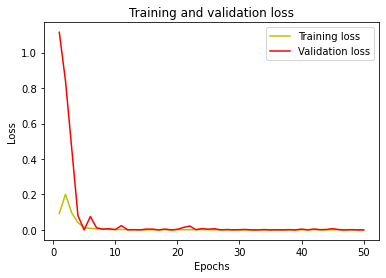

In [35]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

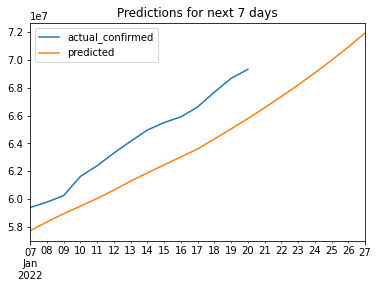

In [36]:

prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]

#Plot
df_forecast.plot(title="Predictions for next 7 days")